In [59]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import math, time
import matplotlib.pyplot as plt

# Data

In [4]:
data = pd.read_csv("..\data\AMD_Price.csv").set_index("Date")

In [8]:
data.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2000-01-03,29.94,31.19,29.38,31.00,3921600.0,0.0,1.0,14.970,15.595,14.690,15.500,7843200.0
2000-01-04,30.25,31.00,29.19,29.25,3145100.0,0.0,1.0,15.125,15.500,14.595,14.625,6290200.0
2000-01-05,29.06,29.38,28.00,29.31,4102300.0,0.0,1.0,14.530,14.690,14.000,14.655,8204600.0
2000-01-06,31.00,32.00,30.50,32.00,5744700.0,0.0,1.0,15.500,16.000,15.250,16.000,11489400.0
2000-01-07,30.81,32.81,30.75,32.50,4271700.0,0.0,1.0,15.405,16.405,15.375,16.250,8543400.0


In [46]:
price = data.reset_index()[["Close"]]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

In [47]:
price

,Close
0,-0.370743
1,-0.408224
2,-0.406939
3,-0.349325
4,-0.338616
...,...
4581,-0.793532
4582,-0.801028
4583,-0.807025
4584,-0.811094


In [83]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, look_back)

In [84]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

# RNN

In [85]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [86]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        # Number of hidden layers
        self.num_layers = num_layers
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

In [87]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [88]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.10343261063098907
Epoch  20 MSE:  0.06219712644815445
Epoch  30 MSE:  0.01914391480386257
Epoch  40 MSE:  0.005697618704289198
Epoch  50 MSE:  0.0020854694303125143
Epoch  60 MSE:  0.0014773013535887003
Epoch  70 MSE:  0.0012680516811087728
Epoch  80 MSE:  0.0011424828553572297
Epoch  90 MSE:  0.0010428399546071887


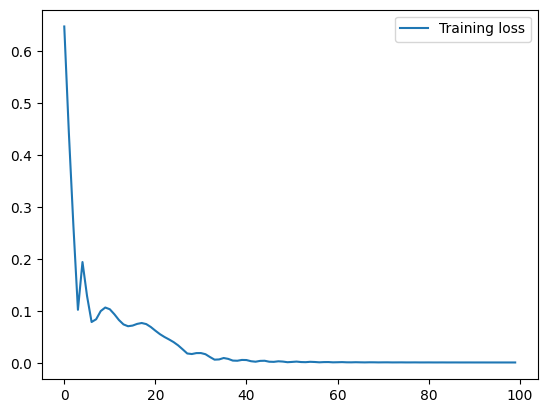

In [89]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [90]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.49 RMSE
Test Score: 0.64 RMSE


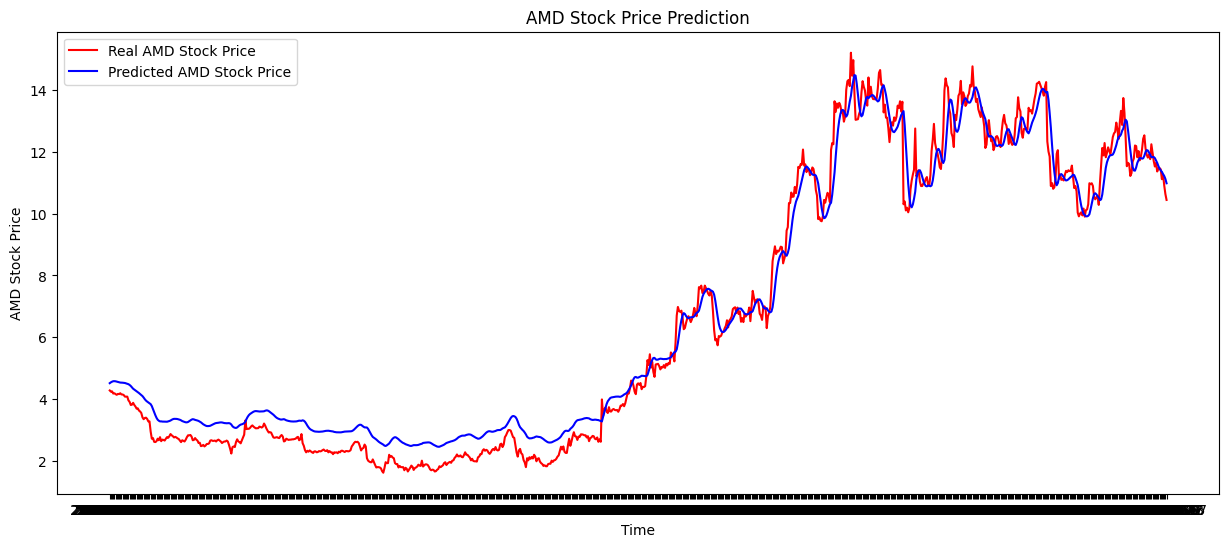

In [92]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(data[len(data)-len(y_test):].index, y_test, color = 'red', label = 'Real AMD Stock Price')
axes.plot(data[len(data)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted AMD Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('AMD Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AMD Stock Price')
plt.legend()
plt.savefig('amd_pred.png')
plt.show()